In [25]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [26]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [27]:
batch_size = 64
num_classes = 10

In [28]:
train_dataset = datasets.MNIST(root='./data',
                                          train = True,
                                          transform = transforms.Compose([
                                              transforms.Resize((32, 32)),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=(1.,), std = (0.5 ))]),
                                           download = True)

test_dataset = datasets.MNIST(root='./data',
                                          train = False,
                                          transform = transforms.Compose([
                                              transforms.Resize((32, 32)),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=(1.,), std = (0.5, ))]),
                                           download = True)

train_loader = DataLoader(dataset = train_dataset,
                          batch_size = batch_size,
                          shuffle = True)

test_loader = DataLoader(dataset = test_dataset,
                          batch_size = batch_size,
                          shuffle = True)

In [29]:
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [34]:
model = LeNet5(num_classes).to(device)

cost = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [35]:
num_epochs = 3

loss_train = []
loss_test = []

total_step = len(train_loader)
for epoch in range(num_epochs):
    sum_loss = 0
    n_batches = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = cost(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sum_loss += loss
        n_batches += 1
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    loss_train.append(sum_loss / n_batches)

    sum_loss = 0
    n_batches = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = cost(outputs, labels)
        sum_loss += loss
        n_batches += 1
    loss_test.append(sum_loss / n_batches)

Epoch [1/3], Step [100/938], Loss: 0.1704
Epoch [1/3], Step [200/938], Loss: 0.1699
Epoch [1/3], Step [300/938], Loss: 0.1281
Epoch [1/3], Step [400/938], Loss: 0.0635
Epoch [1/3], Step [500/938], Loss: 0.0859
Epoch [1/3], Step [600/938], Loss: 0.1108
Epoch [1/3], Step [700/938], Loss: 0.0371
Epoch [1/3], Step [800/938], Loss: 0.0372
Epoch [1/3], Step [900/938], Loss: 0.0856
Epoch [2/3], Step [100/938], Loss: 0.1844
Epoch [2/3], Step [200/938], Loss: 0.0086
Epoch [2/3], Step [300/938], Loss: 0.0068
Epoch [2/3], Step [400/938], Loss: 0.0228
Epoch [2/3], Step [500/938], Loss: 0.0131
Epoch [2/3], Step [600/938], Loss: 0.0742
Epoch [2/3], Step [700/938], Loss: 0.0351
Epoch [2/3], Step [800/938], Loss: 0.0453
Epoch [2/3], Step [900/938], Loss: 0.0223
Epoch [3/3], Step [100/938], Loss: 0.0061
Epoch [3/3], Step [200/938], Loss: 0.0151
Epoch [3/3], Step [300/938], Loss: 0.0553
Epoch [3/3], Step [400/938], Loss: 0.1043
Epoch [3/3], Step [500/938], Loss: 0.0041
Epoch [3/3], Step [600/938], Loss:

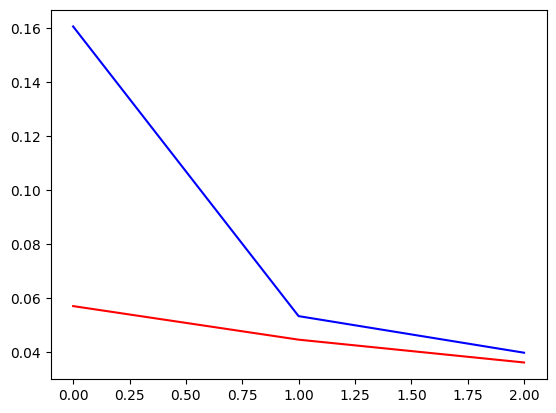

In [36]:
loss_train = np.array(torch.Tensor(loss_train))
loss_test = np.array(torch.Tensor(loss_test))

x = [i for i in range(num_epochs)]

fig, ax = plt.subplots()

ax.plot(x, loss_train, color='blue')
ax.plot(x, loss_test, color='red')

In [37]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 98.87 %
